In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import scipy.stats
import itertools

In [2]:
cell_lines = ['PC-3', 'GM12878', 'K562']
model_name = 'enformer'
optimization_name = 'max'
N_iters = 25
_, cre_tiles = utils.set_tile_range(196608, 5000)
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f"{utils.make_dir(f'{pdf_base_dir}/higher_order_test/')}{optimization_name}/")
summary_csv_dir = f'../results/summary_csvs/enformer/greedy_search/'

# Heatmaps of CRE locations

In [3]:
location_maps = pd.read_csv(f"{summary_csv_dir}/{optimization_name}_locations.csv")

In [4]:
pdf_dir

'pdfs/higher_order_test/max/'

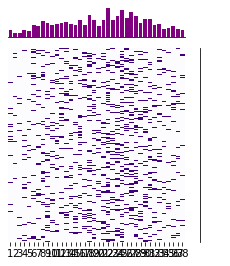

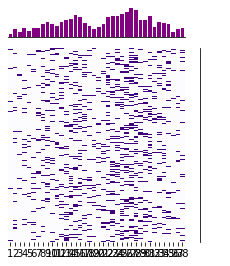

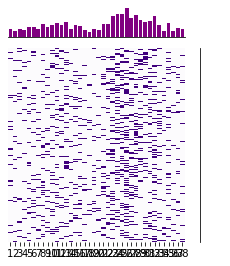

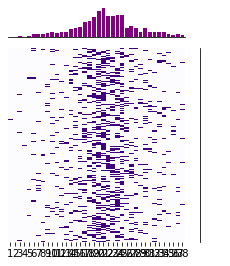

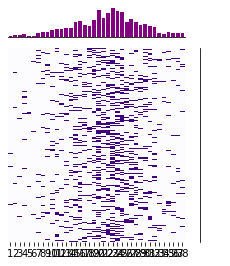

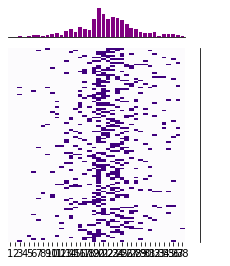

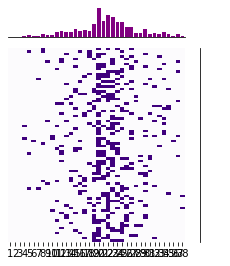

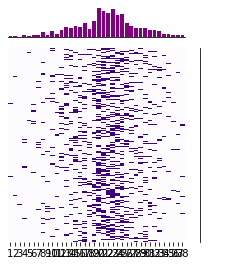

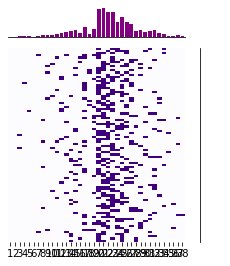

In [6]:
for (context, cell_line), context_maps in location_maps.groupby(['context', 'cell_line']):
    
    v = context_maps['tile_selected'].values.reshape((context_maps.shape[0]//38, 38))
    df = pd.DataFrame(v)
    H, D = df.shape
    df = df.reset_index(names='sequence').melt(id_vars='sequence', var_name='position', value_name='Selected')
    
    df['position'] = [int(p) for p in df['position']]
    g = sns.jointplot(data=df, x='position', y='sequence', kind='hist', bins=(D, H))
    g.ax_marg_y.cla()
    g.ax_marg_x.cla()
    sns.heatmap(data=df['Selected'].to_numpy().reshape(D, H).T.astype('float'), edgecolor="none", linewidth=0, yticklabels=False, xticklabels=False, ax=g.ax_joint, cbar=False, cmap='Purples')
    
    # g.ax_marg_y.barh(np.arange(0.5, H), df.groupby(['hour'])['Cost Dif.'].sum().to_numpy(), color='navy')
    g.ax_marg_x.bar(np.arange(0.5, D), df.groupby(['position'])['Selected'].sum().to_numpy(), color='purple')
    
    g.ax_joint.set_xticks(np.arange(0.5, D))
    g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
    # g.ax_joint.set_yticks(np.arange(0.5, H))
    # g.ax_joint.set_yticklabels(range(H), rotation=0)
    
    # remove ticks between heatmao and histograms
    g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
    g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
    # remove ticks showing the heights of the histograms
    g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
    g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)
    
    g.fig.set_size_inches(3.3, 3.8)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
    #g.fig.suptitle(f'{cell_line} {context}')
    plt.tight_layout()

    plt.savefig(f'{pdf_dir}/silencer_distribution_{cell_line}_{context}.pdf')
    plt.show()


# Traces 

In [7]:
all_traces = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_traces.csv', index_col='Unnamed: 0')

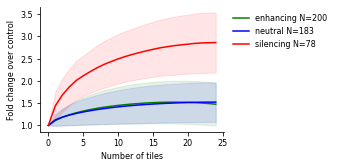

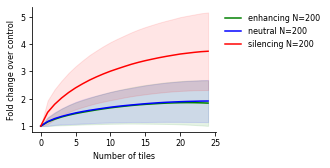

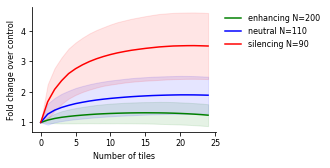

In [11]:
fontsize=8
color_map = {'enhancing': 'g', 'neutral':'b', 'silencing':'r'}
for (cell_line), all_context_data in all_traces.groupby('cell_line'):

    fig, ax = plt.subplots(1, 1, figsize=[3.3,2.3])
    for context, data in all_context_data.groupby('context'):
        data = data['trace'].values.reshape((data.shape[0]//N_iters, N_iters))
    
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        color = color_map[context]
        ax.plot(mean, c=color, alpha=1, label=f'{context} N={data.shape[0]}')
        ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)

    plt.legend(frameon=False, bbox_to_anchor=[1.6,1], fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.xlabel('Number of tiles', fontsize=fontsize)
    plt.ylabel('Fold change over control', fontsize=fontsize)
    fig.savefig(f'{pdf_dir}/{cell_line}_silencer_search.pdf')

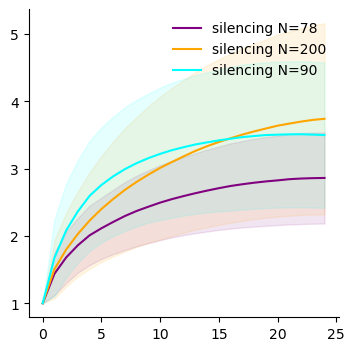

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[4,4])
colors = ['purple', 'orange', 'cyan']
for i, (cell_line, df) in enumerate(all_traces.groupby('cell_line')):
    df = df[df['context']=='silencing']
    data = df['trace'].values.reshape((df.shape[0]//N_iters, N_iters))
  

    mean = data.mean(axis=0)
    std = data.std(axis=0)
    color = color_map[context]
    ax.plot(mean, c=colors[i], alpha=1, label=f'{context} N={data.shape[0]}')
    ax.fill_between(range(N_iters), mean-std, mean+std, alpha=0.1, color=colors[i])

    plt.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.savefig(f"{pdf_dir}/cell_line_comparison.pdf")


# Hypothetical additive model

In [8]:
all_traces = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_traces.csv', index_col='Unnamed: 0')

/tmp/ipykernel_3211668/398419444.py:42: RuntimeWarning: Mean of empty slice.
  t_mean = t.mean(axis=0)
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_3211668/398419444.py:42: RuntimeWarning: Mean of empty slice.
  t_mean = t.mean(axis=0)
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/

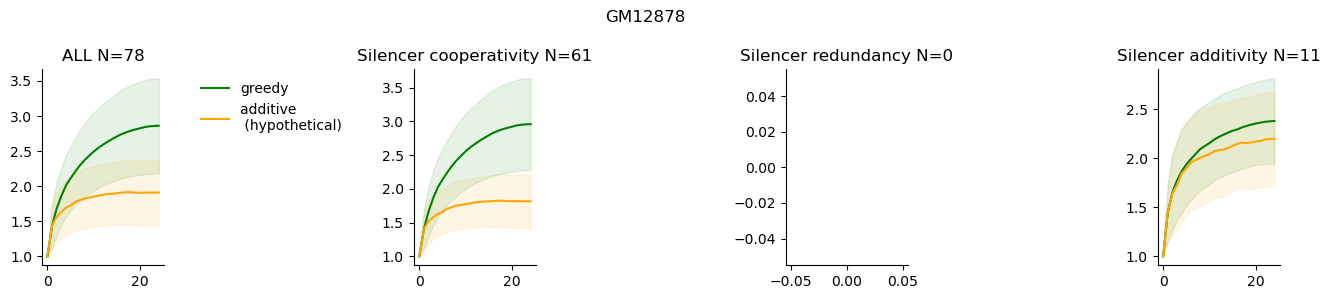

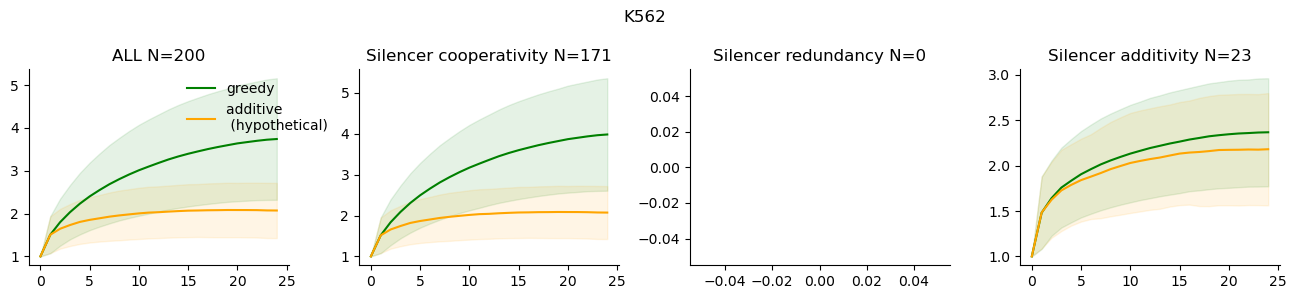

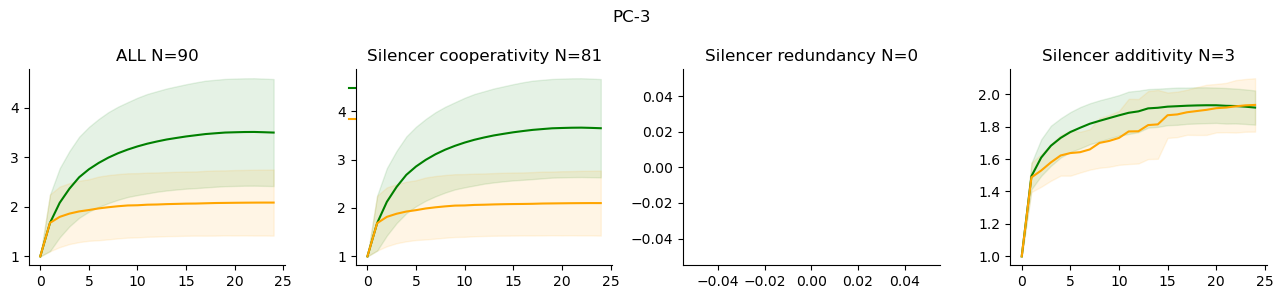

In [9]:
strata = {}
strata_seq_ids = []
for cell_line, cell_df in all_traces.groupby('cell_line'):
    sign = []
    MSE = []
    cell_enhancing_df = cell_df[cell_df['context']=='silencing']
    L = cell_enhancing_df.shape[0]
    enhancing_greedy = cell_enhancing_df['trace'].values.reshape(L//N_iters, N_iters)
    enhancing_hyp = cell_enhancing_df['hypothetical_trace'].values.reshape(L//N_iters, N_iters)
    for trace, hypothetical_trace in zip(enhancing_greedy, enhancing_hyp):
        MSE.append(mean_squared_error(trace, hypothetical_trace))
        sign.append(np.mean(trace) - np.mean(hypothetical_trace))
    MSE = np.array(MSE) 

    colors = ['green', 'orange']
    labels = ['cooperative', 'additive']
    titles = ['ALL', 'Silencer cooperativity', 'Silencer redundancy', 'Silencer additivity']
    # i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
    
    pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.1]
    neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.1]
    zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.05]
    seq_ids = cell_enhancing_df['seq_id'].values.reshape(L//N_iters, N_iters)[:,0]
    strata[cell_line] = {'cooperativity': pos_points, 'redundancy': neg_points, 'additivity': zero_points}
    for label_stratum, point_indexes in strata[cell_line].items():
        df_per_stratum = pd.DataFrame(seq_ids[point_indexes])
        df_per_stratum.columns = ['seq_id']
        df_per_stratum['cell_line'] = cell_line
        df_per_stratum['label'] = label_stratum
        strata_seq_ids.append(df_per_stratum)
    all_points = np.arange(len(sign))

    fig, axes = plt.subplots(1, len(titles), figsize=[13, 3])
    curve_labels = ['greedy', 'additive \n (hypothetical)']
    
    for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):
        ax = axes[p]
        ax.set_title(f'{titles[p]} N={len(points)}')
        trace_set, hypothetical_trace_set = enhancing_greedy[points], enhancing_hyp[points]
        for i, t in enumerate([trace_set, hypothetical_trace_set]):
            
            t_mean = t.mean(axis=0)
            t_std = t.std(axis=0)
            ax.plot(t_mean, color=colors[i], alpha=1, label=curve_labels[i])
        
            ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.set_xlim(0, 5)
    axes[0].legend(frameon=False, bbox_to_anchor=[1.2,1])
    plt.suptitle(cell_line)
    plt.tight_layout()
    fig.savefig(f'{pdf_dir}/{cell_line}_greedy_vs_additive.pdf')
strata_seq_ids = pd.concat(strata_seq_ids)

# Hypothetical multiplicative model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


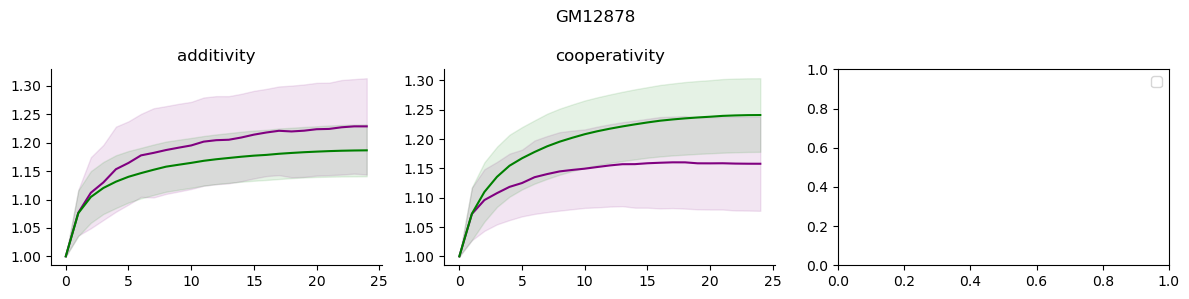

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


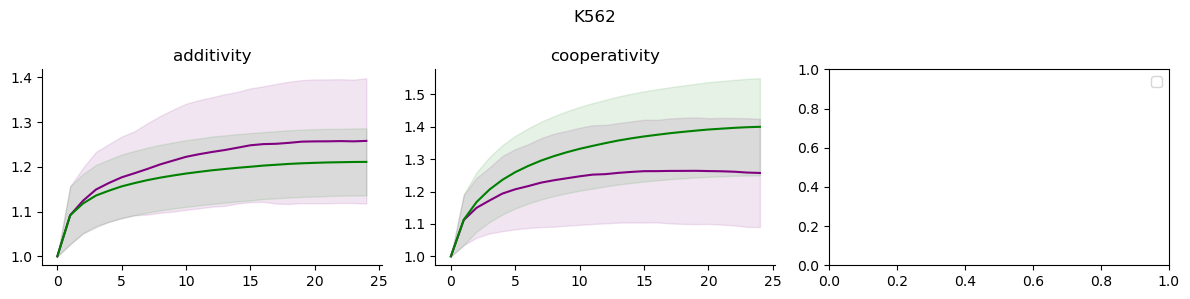

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


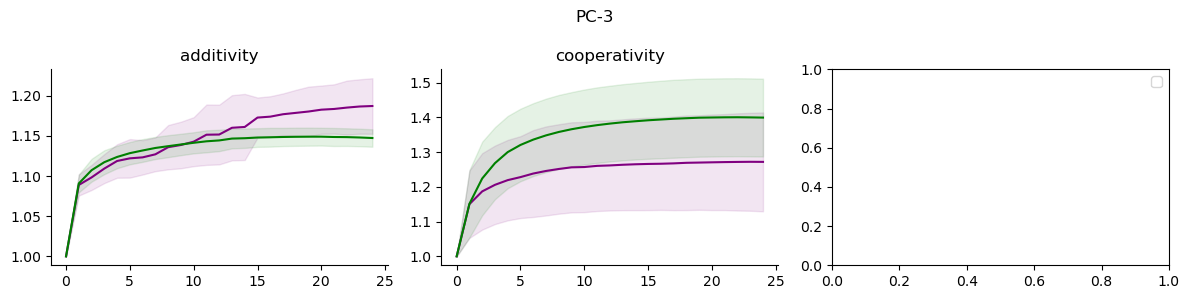

In [10]:
all_traces = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_traces.csv', index_col='Unnamed: 0')
colors = ['purple', 'green']
for cell_line, cell_line_df in all_traces.merge(strata_seq_ids, on=['seq_id', 'cell_line']).groupby('cell_line'):
    fig, axes = plt.subplots(1, 3, figsize=[12, 3])
    for g, (group, df) in enumerate(cell_line_df.groupby('label')):
        ax = axes[g]
        N = df.shape[0]
        for l, label in enumerate(['log_hypothetical_trace', 'log_trace']):
            x = df[label].values.reshape(N//N_iters, N_iters)
            
            mean = x.mean(axis=0)
            std = x.std(axis=0)
            ax.plot(mean, c=colors[l], label=label)
            ax.fill_between(range(N_iters), mean-std, mean+std, alpha=0.1, color=colors[l])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(group)
        # ax.set_xlim(0, 5)
    plt.suptitle(cell_line)
    plt.tight_layout()
    plt.legend()
    fig.savefig(f"{pdf_dir}/{cell_line}_multiplicative_model.pdf")
    plt.show()

# 2nd point comparison


In [11]:
second_it_all = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_second_iteration.csv', index_col='Unnamed: 0')

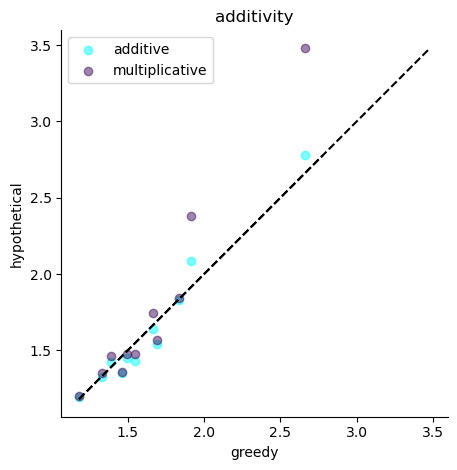

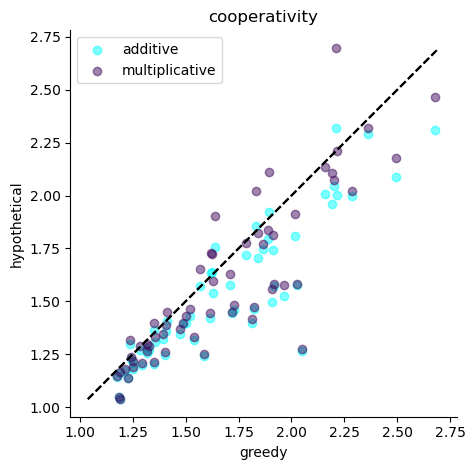

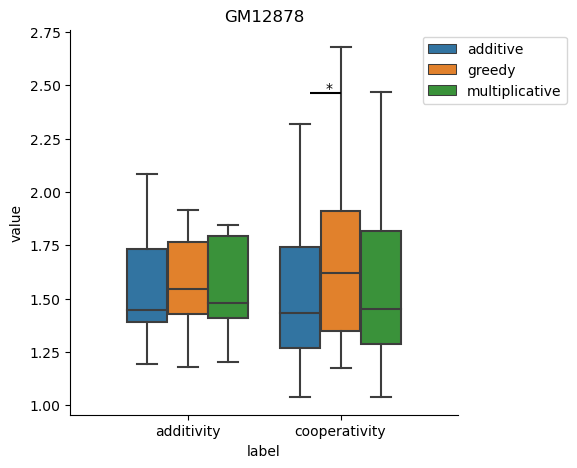

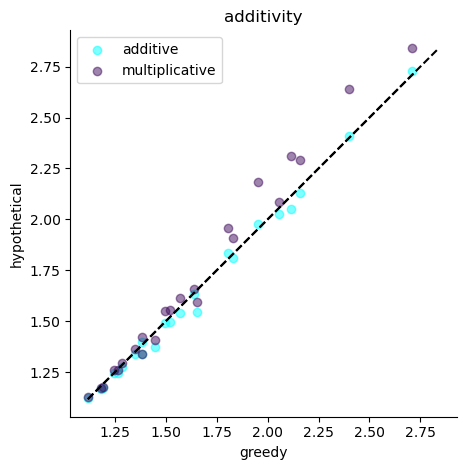

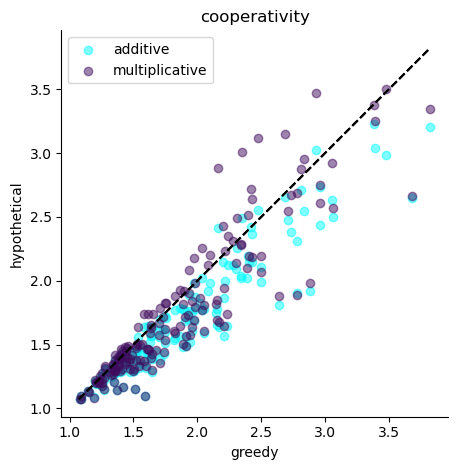

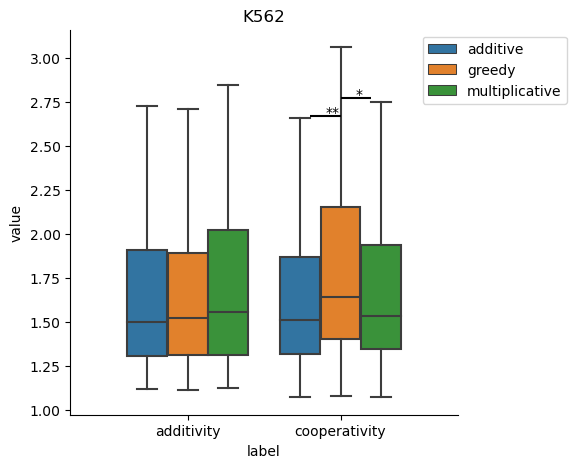

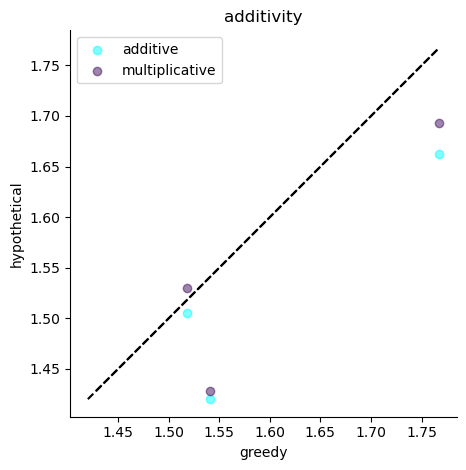

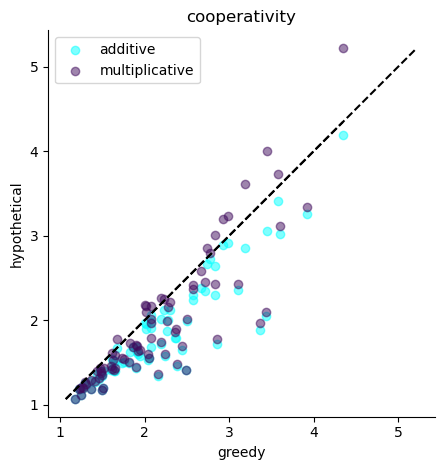

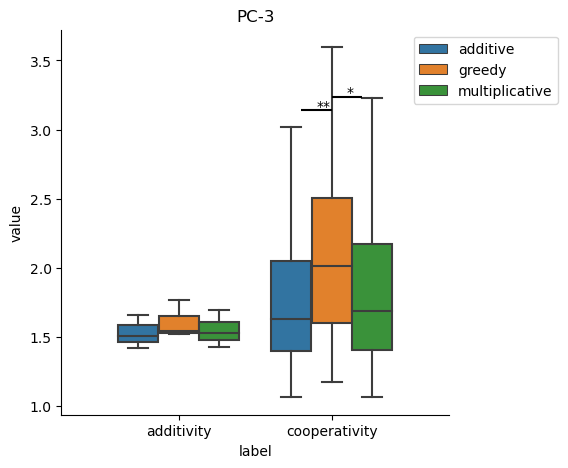

In [12]:
order=['additivity', 'cooperativity']
hue_order=['additive', 'greedy', 'multiplicative']
context = 'silencing'


for cell_line, df_cell_line in second_it_all.groupby('cell_line'): 
    
    df_cell_line = df_cell_line[df_cell_line['context']==context] # filter enhancing contexts only
    hypothetical_additive = []
    hypothetical_multiplicative = []
    greedy = []
    seq_ids = []
    for d, (_, data_point) in enumerate(df_cell_line.groupby('seq_id')):
        # WT, p1=prediction when the 1st CRE is shuffled (based on iter1), 
        # p2=prediction when the 2nd CRE is shuffled (based on iter1), 
        # greedy_res = both 1st and 2nd CREs shuffled
        wt, p1, p2, greedy_res = (data_point.iloc[:, 0].values) 
        log_wt, log_p1, log_p2, _ = [np.log(i) for i in data_point.copy().iloc[:,0].values] # same but based on log values
        # record everything
        hypothetical_additive.append((wt + (p1 - wt) + (p2 - wt))/wt) # (WT + effectsize1 + effectsize2) / WT
        hypothetical_multiplicative.append((np.exp(log_wt + (log_p1 - log_wt) + (log_p2 - log_wt)))/wt)
        greedy.append(greedy_res/wt)
        seq_ids.append(data_point['seq_id']['wt'])
    df = pd.DataFrame([hypothetical_additive, hypothetical_multiplicative, greedy, seq_ids]).T
    df.columns = ['additive', 'multiplicative', 'greedy', 'seq_id']
    strata_ids = strata_seq_ids[strata_seq_ids['cell_line']==cell_line]
    df = df.merge(strata_ids, on='seq_id')
    data=df[['additive', 'multiplicative', 'greedy', 'label']].melt(value_vars=['additive', 'multiplicative', 'greedy'], 
                                                               id_vars='label')

    # test box plot elements for significant differences using MannW
    annotations = []
    for s_i, stratum in enumerate(order): # for each group - 'additivity', 'cooperativity', 'redundancy'
        df_stratum = df[df['label']==stratum]  
        y_counter = 0
        for p, pair_index in enumerate(list(itertools.combinations(range(3), 2))): # for each pair

            
            model_type1, model_type2 = hue_order[pair_index[0]], hue_order[pair_index[1]]
            p_sign = utils.convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(df_stratum[model_type1].astype(float), 
                                                                                df_stratum[model_type2].astype(float))[1])
            if p_sign!= 'ns': # if significant
                
                # compute hight of box removing outliers
                Q1 = np.quantile(df_stratum['multiplicative'], 0.25)
                Q3 = np.quantile(df_stratum['multiplicative'], 0.75)  
                IQR = Q3 - Q1
                lim = Q3 + 1.5 * IQR  
                annotations.append([s_i-0.2, y_counter, pair_index, p_sign, lim*1.05])
                y_counter += 0.1 # push the bar a bit up to avoid overlaps

        # Plot scatterplots of greedy VS additive/multiplicative
        fig, ax = plt.subplots(1, 1)
        for p, (x, y) in enumerate([['greedy', 'additive'], ['greedy', 'multiplicative']]):

            ax.set_aspect('equal', adjustable='box')
            ax.scatter(df_stratum[x], df_stratum[y],color=['cyan', '#400c5d'][p], label=y, alpha=0.5)

            # add X=Y line
            min_point, max_point = df_stratum[[x, y]].min().min(), df_stratum[[x, y]].max().max()
            ax.plot([min_point, max_point], [min_point, max_point], color='k', linestyle='--')
            ax.set_title(stratum)
            ax.set_xlabel(x)
            ax.set_ylabel('hypothetical')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        plt.legend()
        plt.tight_layout()
        fig.savefig(f"{pdf_dir}/2nd_point_comparison_{cell_line}_scatterplot_greedy_vs_hypothetical.pdf")
        plt.show()
        
    fig, ax = plt.subplots(1, 1, figsize=[5, 5])
    sns.boxplot(data=data, x='label', y='value', showfliers=False, 
                   hue='variable', ax=ax,
                order=order, hue_order=hue_order)
    # plt.title(f"{cell_line} {context}")
    for (s_i, y_counter, pair_index, p_sign, y_max) in annotations:
        x1, x2 = s_i+pair_index[0]*0.2, s_i+pair_index[1]*0.2
        y = y_max*0.9+y_counter
        plt.hlines(y, x1, x2, color='k')
        plt.annotate(p_sign, ((x1+x2)/2, y))
    plt.title(cell_line)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(bbox_to_anchor=[1.3, 1])
    fig.savefig(f"{pdf_dir}/2nd_point_comparison_{cell_line}_boxplot.pdf")


    plt.show()
